# Convergent approaches to AI Explainability for HEP muonic particles pattern recognition

# 2) xAI and Knowledge Distillation

The aim of this notebook is to provide explainability leveraging *Knowledge Distillation* techniques to distill knowledge from a teacher model (DNN/CNN) to a student model that is **intrisically explainable** and also simplified (Decision Tree).

## Environment setup

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import math
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # if plotting the kernel crashes
import random

import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from models.cnn import build_cnn
from models.convsdt import *

from utils.dataset import XaiDataset
from utils.plot import plot_logs, plot_cm
from utils.metrics import spread, efficiency

random.seed(0)

print('Libraries imported')

### Downloading data

In [2]:
# get data from my Drive, it downloads (and unzip) less stuff (i.e. only the used one) and data are already splitted
# ! rm -rf sample_data
# ! pip install --upgrade --no-cache-dir gdown -q
# ! gdown --id 1s6JZuJPAqUtnnvezDepApE4BMKo3FP4q
# print('\nUnzipping data...')
# ! unzip -q muontriggerdata-master.zip
# ! rm -rf muontriggerdata-master.zip

print('\nLoading images with noise...')
train_images = np.load('../muontriggerdata-master/train_images_with_noise.npy')
test_images = np.load('../muontriggerdata-master/test_images_with_noise.npy')

print('\nLoading images without noise...')
train_images_without_noise = np.load('../muontriggerdata-master/train_images_without_noise.npy')
test_images_without_noise = np.load('../muontriggerdata-master/test_images_without_noise.npy')

print('\nLoading labels...')
train_labels = np.load('../muontriggerdata-master/train_labels.npy')
test_labels = np.load('../muontriggerdata-master/test_labels.npy')

print('\nLoading completed.')

## Data Preprocessing

Our work is focused **ONLY** on predicting values for *pt* and *eta*; therefore, we will drop the remaining parameters in the labels.

In [3]:
train_labels = np.array([train_label[:2] for train_label in train_labels])
test_labels = np.array([test_label[:2] for test_label in test_labels])

print(train_labels.shape)
print(test_labels.shape)

In [4]:
train_labels_pre = train_labels
test_labels_pre = test_labels

train_labels_df = pd.DataFrame(train_labels_pre, columns=['pt', 'eta'], copy=True)
test_labels_df = pd.DataFrame(test_labels_pre, columns=['pt', 'eta'], copy=True)

test_labels_df.head()

And then we normalize the original labels $y'$ as $y = \frac{(y' - μ)}{σ}$, where the mean $\mu$ and the standard deviation $σ$ of the training set are taken from the ```data_analysis``` notebook.

In [5]:
kd = True # are we testing a model trained via Knowledge Distillation?
MEAN = 11.863591194152832 if kd else train_labels_df.mean()['pt']
STD = 4.761418342590332 if kd else train_labels_df.std()['pt']

train_labels[:,0] = (train_labels[:,0] - MEAN) / STD
test_labels[:,0] = (test_labels[:,0] - MEAN) / STD

test_labels[:5]

## Regression with Knowledge Distillation

### Customized metrics definition

According to our instructions, we want a model able to select muons with $pt$ greater than a fixed threshold ($>= 10$ GeV) with the highest possible efficiency. Moreover, it should be able to discard muons with $pt$ lower than such threshold ($< 10$ GeV).

We can do that by defining two metrics:
* **spread**, distribution of the quantity $(pt_{true} - pt_{pred})$ around the threshold of $10$ GeV (let's say $[7-8, 12-13]$ GeV). This metric should be as low as possible.
* **efficiency**, number of muons with $pt_{true} > 15$ GeV and $pt_{pred} > 15$ GeV over the number of muons with $pt_{true} > 15$ GeV. This metric should be as high as possible.

Therefore, we will create our customized metrics to be used in the during the training and the evaluation of the model.


### Starting with a student baseline:
#### ***Convolutional Soft Decision Tree (ConvSDT)*** for Regression

Briefly, **Soft Decision Trees (SDTs)** are models that combine the befenits of a Deep Learning approach, namely high accuracy with high-dimensional and large amount of data, with the possibility to explain predictions typical of intrinsically explainable architectures like *Decision Trees*. Differently from these very simple models that take "hard" and exclusive choices while selecting the next node in the decision process, the "softness" of the SDT consists in the capability to consider each output leaf node with a specific probability that will contribute to the final outcome of the model.

***Convolution SDTs*** are an improvement of this model with Convolutional layers on top to provide a latent representation of the input data to be passed to the hierarchical mixture of the trees.

First of all, we need to re-adapt data for PyTorch: use a standard routine to group *Numpy array*s into ```torch.utils.data.DataLoader```s. 



In [6]:
# our numpy data and dataframes ---> torch tensors
train_images = train_images.reshape(-1, 1, 9, 384)
test_images = test_images.reshape(-1, 1, 9, 384)
train_labels = train_labels.reshape(-1, 2)
test_labels = test_labels.reshape(-1, 2)

train_images = torch.tensor(train_images, dtype=torch.float32)
test_images = torch.tensor(test_images, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

train_data_list = []

for x, y in zip(train_images, train_labels):
    train_data_list.append((x, y))

test_data_list = []

for x, y in zip(test_images, test_labels):
    test_data_list.append((x, y))

In [7]:
train_dataset = XaiDataset(train_data_list)
train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataset = XaiDataset(test_data_list)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# let us inspect the testing Dataloader
for batch in test_dataloader:
    X, y = batch
    print(X[0])
    print(y[0])
    print(f"\nbatch X shape: {X.shape}")
    print(f"batch y shape: {y.shape}")
    break

#### ConvSDT Training

Let's train the baseline.

In [ ]:
# suggestion: SDT runs faster on cpu rather than on gpu/cuda
model = ConvSDT(latent_dim=768, output_dim=2, depth=5)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss() # = mae in PyTorch

logs = train_and_evaluate(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    save_path='convSDT_model.pth',
    epochs=5,
    verbose=True,
    mean=MEAN,
    std=STD,
)

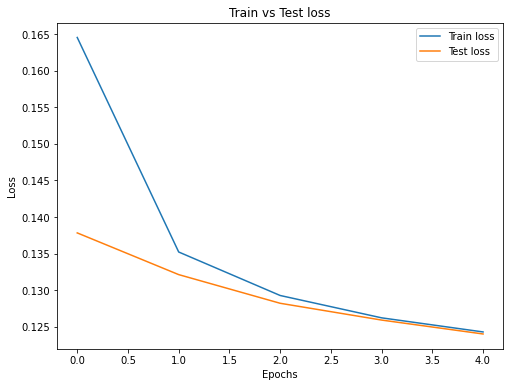

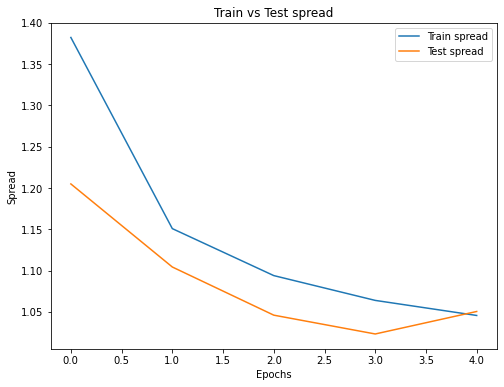

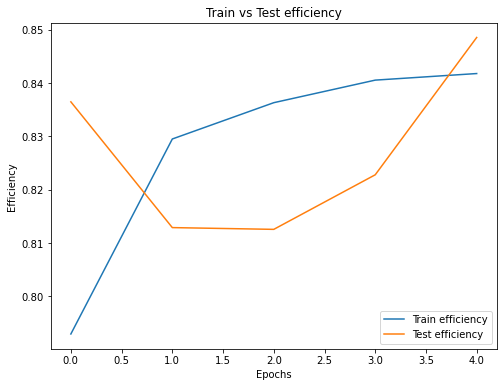

In [ ]:
plot_logs(logs)

#### ConvSDT Evaluation

Evaluating the baseline.

In [9]:
# load model
model = ConvSDT(latent_dim=768, output_dim=2, depth=5)
model.load_state_dict(torch.load('ckpts/convSDT_model.pth'))
model.eval()

In [10]:
compare_df = evaluate_model(model, test_dataloader, test_labels, test_labels_df, mean=MEAN, std=STD)

Spread: 1.050466, Efficiency: 0.848880
          pt       eta    pt_pred  eta_pred
0  13.491201  0.053108  15.023849  0.059356
1   4.227651  0.205530   3.928883  0.223781
2  13.979775  0.651565  13.662012  0.644305
3  14.510050  0.939512  15.744331  0.924130
4  10.261550  0.116171  10.346474  0.116873
5  18.524986  0.279401  18.347988  0.270369
6   6.452104  0.492939   6.805209  0.503685
7  15.881395  0.705206  16.274885  0.731090
8   9.464007  0.130429  10.058129  0.147729
9  11.706838  0.358624  10.439795  0.356817


In [ ]:
# inverse scaling to find the coorect loss value
np.mean((compare_df['pt']-compare_df['pt_pred']).abs() + (compare_df['eta']-compare_df['eta_pred']).abs())/2

### Distilling knowledge from the teacher model to the student

We need to import and load the weights of the CNN developed in the previous notebook, ```xai_attribution.ipynb```.

Then, we will use this teacher to extract and create **soft labels** to be passed to the student model as training labels.

In [8]:
teacher = build_cnn()
teacher.load_weights('ckpts/cnn_model/cnn_model')

teacher.compile(loss='mae',
                metrics=[spread, efficiency],
                optimizer='adam')
teacher.summary()

The following labels can be used both for *pt* and for *eta*.

In [9]:
train_labels_soft = teacher.predict(tf.convert_to_tensor(train_images.numpy().reshape(-1, 9, 384, 1)))   
train_labels_soft.shape

In [10]:
MEAN_KD = tf.math.reduce_mean(train_labels_soft[:, 0])
STD_KD = tf.math.reduce_std(train_labels_soft[:, 0])
print(f"mean: {MEAN_KD}, std: {STD_KD}")

train_labels_soft[:, 0] = (train_labels_soft[:, 0] - MEAN_KD) / STD_KD

train_labels_soft = torch.tensor(train_labels_soft, dtype=torch.float32)

train_data_list = []

for x, y in zip(train_images, train_labels_soft):
    train_data_list.append((x, y))

train_dataset_soft = XaiDataset(train_data_list)
train_dataloader_soft = DataLoader(train_dataset_soft, batch_size=64)

# let us inspect the training Dataloader
for batch in train_dataloader_soft:
    X, y = batch
    print(X[0])
    print(y[0])
    print(f"\nbatch X shape: {X.shape}")
    print(f"batch y shape: {y.shape}")
    break

#### Distilled SDT Training

Applying **Knowledge Distillation (KD)**.

In [ ]:
# suggestion: SDT runs faster on cpu rather than on gpu/cuda
model = ConvSDT(latent_dim=768, output_dim=2, depth=5)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss() # = mae in PyTorch

logs = train_and_evaluate(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader_soft,
    test_dataloader=test_dataloader,
    save_path='ckpts/convSDT_model_distilled.pth',
    epochs=5,
    verbose=True,
    mean=MEAN_KD,
    std=STD_KD,
)

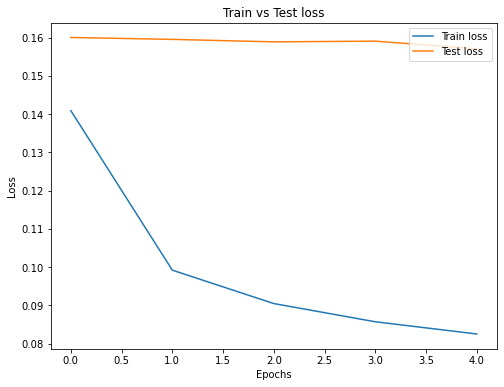

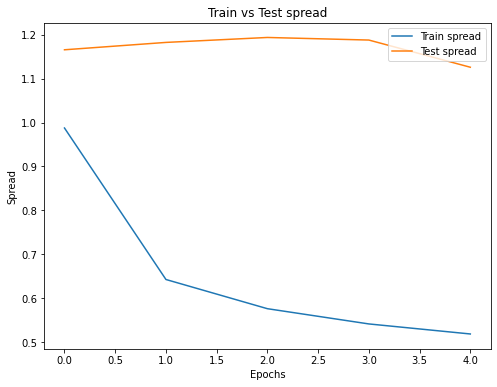

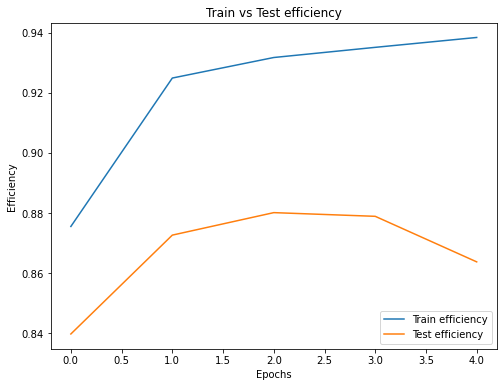

In [ ]:
plot_logs(logs)

#### Distilled SDT Evaluation

Evaluating the distiled model, we can see the improvements introduced with KD.

In [8]:
# load model
model = ConvSDT(latent_dim=768, output_dim=2, depth=5)
model.load_state_dict(torch.load('ckpts/convSDT_model_distilled.pth'))
model.eval()

In [9]:
# just to not run teacher again
MEAN_KD = 11.863591194152832
STD_KD = 4.761418342590332

compare_df = evaluate_model(model, test_dataloader, test_labels, test_labels_df, MEAN_KD, STD_KD)

Spread: 1.268763, Efficiency: 0.886388
          pt       eta    pt_pred  eta_pred
0  13.491201  0.053108  14.940195  0.080017
1   4.227651  0.205530   4.555439  0.327941
2  13.979775  0.651565  13.113233  0.793228
3  14.510050  0.939512  14.952989  0.872775
4  10.261550  0.116171  10.163941  0.097005
5  18.524986  0.279401  18.357885  0.286254
6   6.452104  0.492939   6.835257  0.535882
7  15.881395  0.705206  15.608002  0.812222
8   9.464007  0.130429  10.788882  0.421435
9  11.706838  0.358624  11.581059  0.400840


In [ ]:
# inverse scaling to find the correct loss value
np.mean((compare_df['pt']-compare_df['pt_pred']).abs() + (compare_df['eta']-compare_df['eta_pred']).abs())/2

## ConvSDT Explainability

Thanks to its hierarchical structure, ConvSDT are very easy to explain. We will provide a visualization procedure to plot the input image at each step of the processing (convolutions, passage to SDT and flow through the nodes), we will highlight the *maximum probability path* but we will also quantify the "weight" of each leaf for the final prediction.

In [8]:
model = ConvSDT(latent_dim=768, output_dim=2, depth=5)
model.load_state_dict(torch.load('ckpts/convSDT_model_distilled.pth'))
model.eval()

### Interesting study cases:

#### a. Selected events inspection

We can now inspect specific correctly or wrongly selected images and provide the related explanations from the network.
Note that we have a correct selection when the model predicts a $pt_{pred} > 15$ GeV given that $pt_{true} > 15$ GeV.

We can do that by first constructing a "*confusion matrix*" with the ```True/False Positives/Negatives``` events and then inspect each of these classification regions.

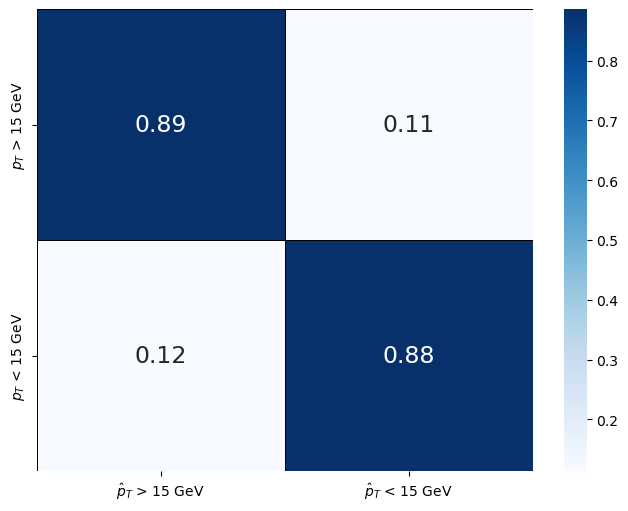

In [10]:
tp_index, fn_index, fp_index, tn_index, cm_plot = plot_cm(compare_df)

##### a.1. Correctly selected events inspection

Let's now evaluate the explanations of the network with the correctly selected images (i.e. where particles have **both** actual and predicted $pt >$ or $< 15$ GeV) by visualizing the related heatmaps.

In this cases, the leaf node's output with the highest probability is very close to the ground-truth label, as expected. The smaller contributions of the other leaves will guarantee a further refinement in the final prediction.

In [9]:
# just to not run teacher again
STD_KD = 4.761418342590332
MEAN_KD = 11.863591194152832

There are 25286 true positives selected events.
There are 58325 true negatives selected events.

##################################################  True Positives inspection  ##################################################
Explanation for test image 47011


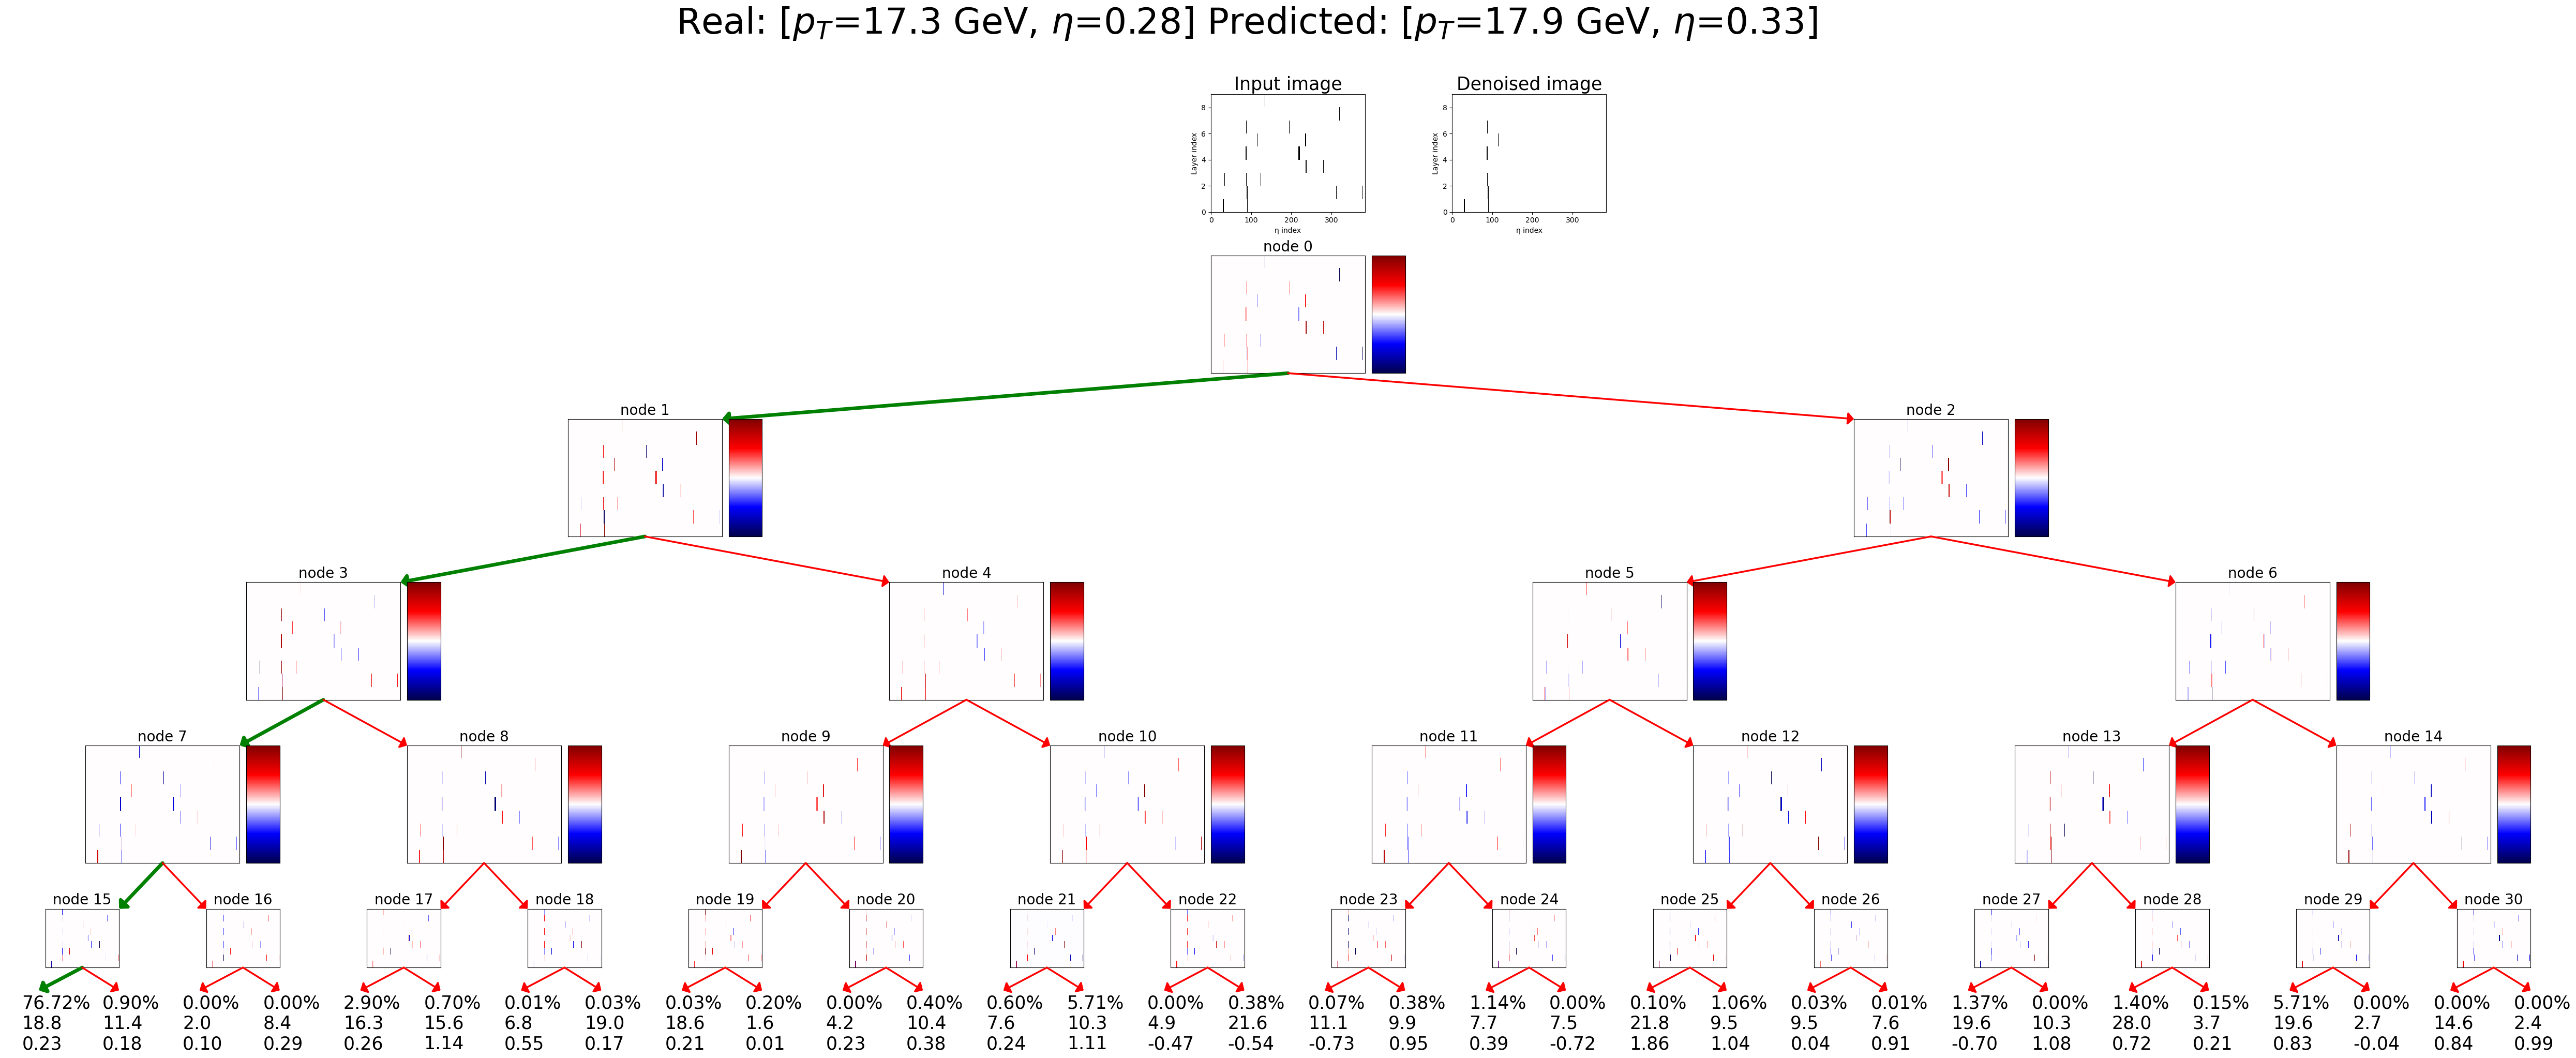


 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

##################################################  True Negatives inspection  ##################################################
Explanation for test image 34311


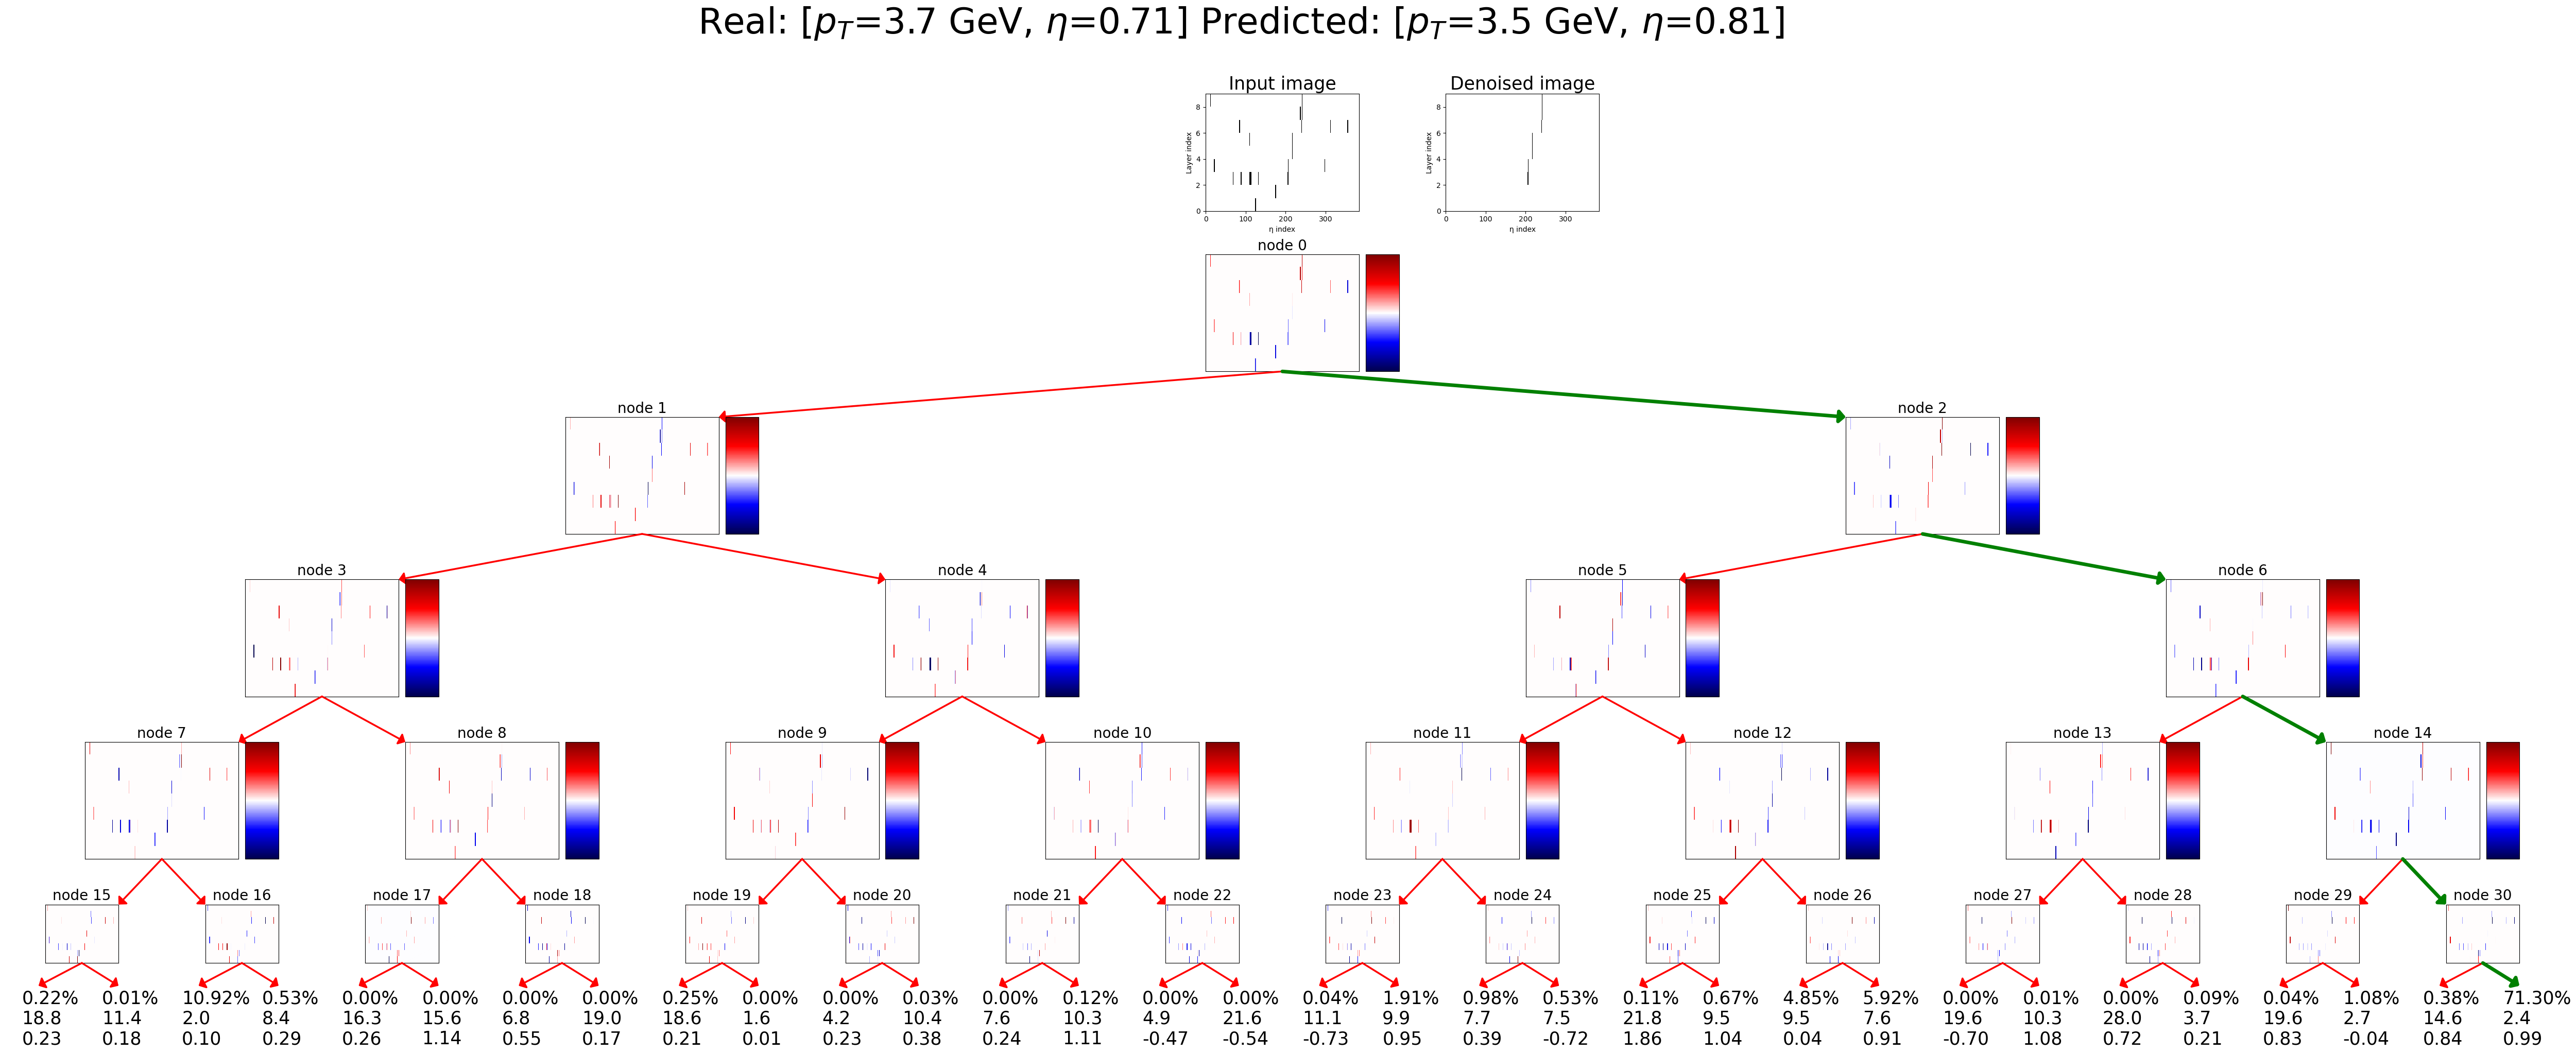


 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [15]:
# inspect correctly selected events
print(f'There are {len(tp_index)} true positives selected events.')
print(f'There are {len(tn_index)} true negatives selected events.\n')

print('#'*50, ' True Positives inspection ', '#'*50)
index = random.choice(tp_index)
print('Explanation for test image ' + str(index))
explain_image(model, test_images[index], test_labels[index][0], test_labels[index][1], test_images_without_noise[index], mean=MEAN_KD, std=STD_KD, title='tp.jpg')
print('\n', '-'*160, '\n')

print('#'*50, ' True Negatives inspection ', '#'*50)
index = random.choice(tn_index)
print('Explanation for test image ' + str(index))
explain_image(model, test_images[index], test_labels[index][0], test_labels[index][1], test_images_without_noise[index], mean=MEAN_KD, std=STD_KD, title='tn.jpg')
print('\n', '-'*160, '\n')

##### a.2. Wrongly selected events inspection

Consequently, it is crucial to analyze the case where the network is wrong, namely it predicts a $pt_{pred} > 15$ GeV for images with a $pt_{true}$ under the threshold of interest of $10$ GeV and viceversa.

In particular, we focus on cases where the model error is higher than usual; as instance, filtering only when $|pt_{true} - pt_{pred}| > 5$ GeV.

In these other cases instead, we can see how the model takes the "wrong way" to a leaf node that outputs a different prediction with respect to the ground-truth, the contribution of the other leaves is too poor to overcome such error.

There are 7593 false positives selected events.
There are 3241 false negatives selected events.

############################################################  False Positives inspection  ############################################################
Explanation for test image 29978


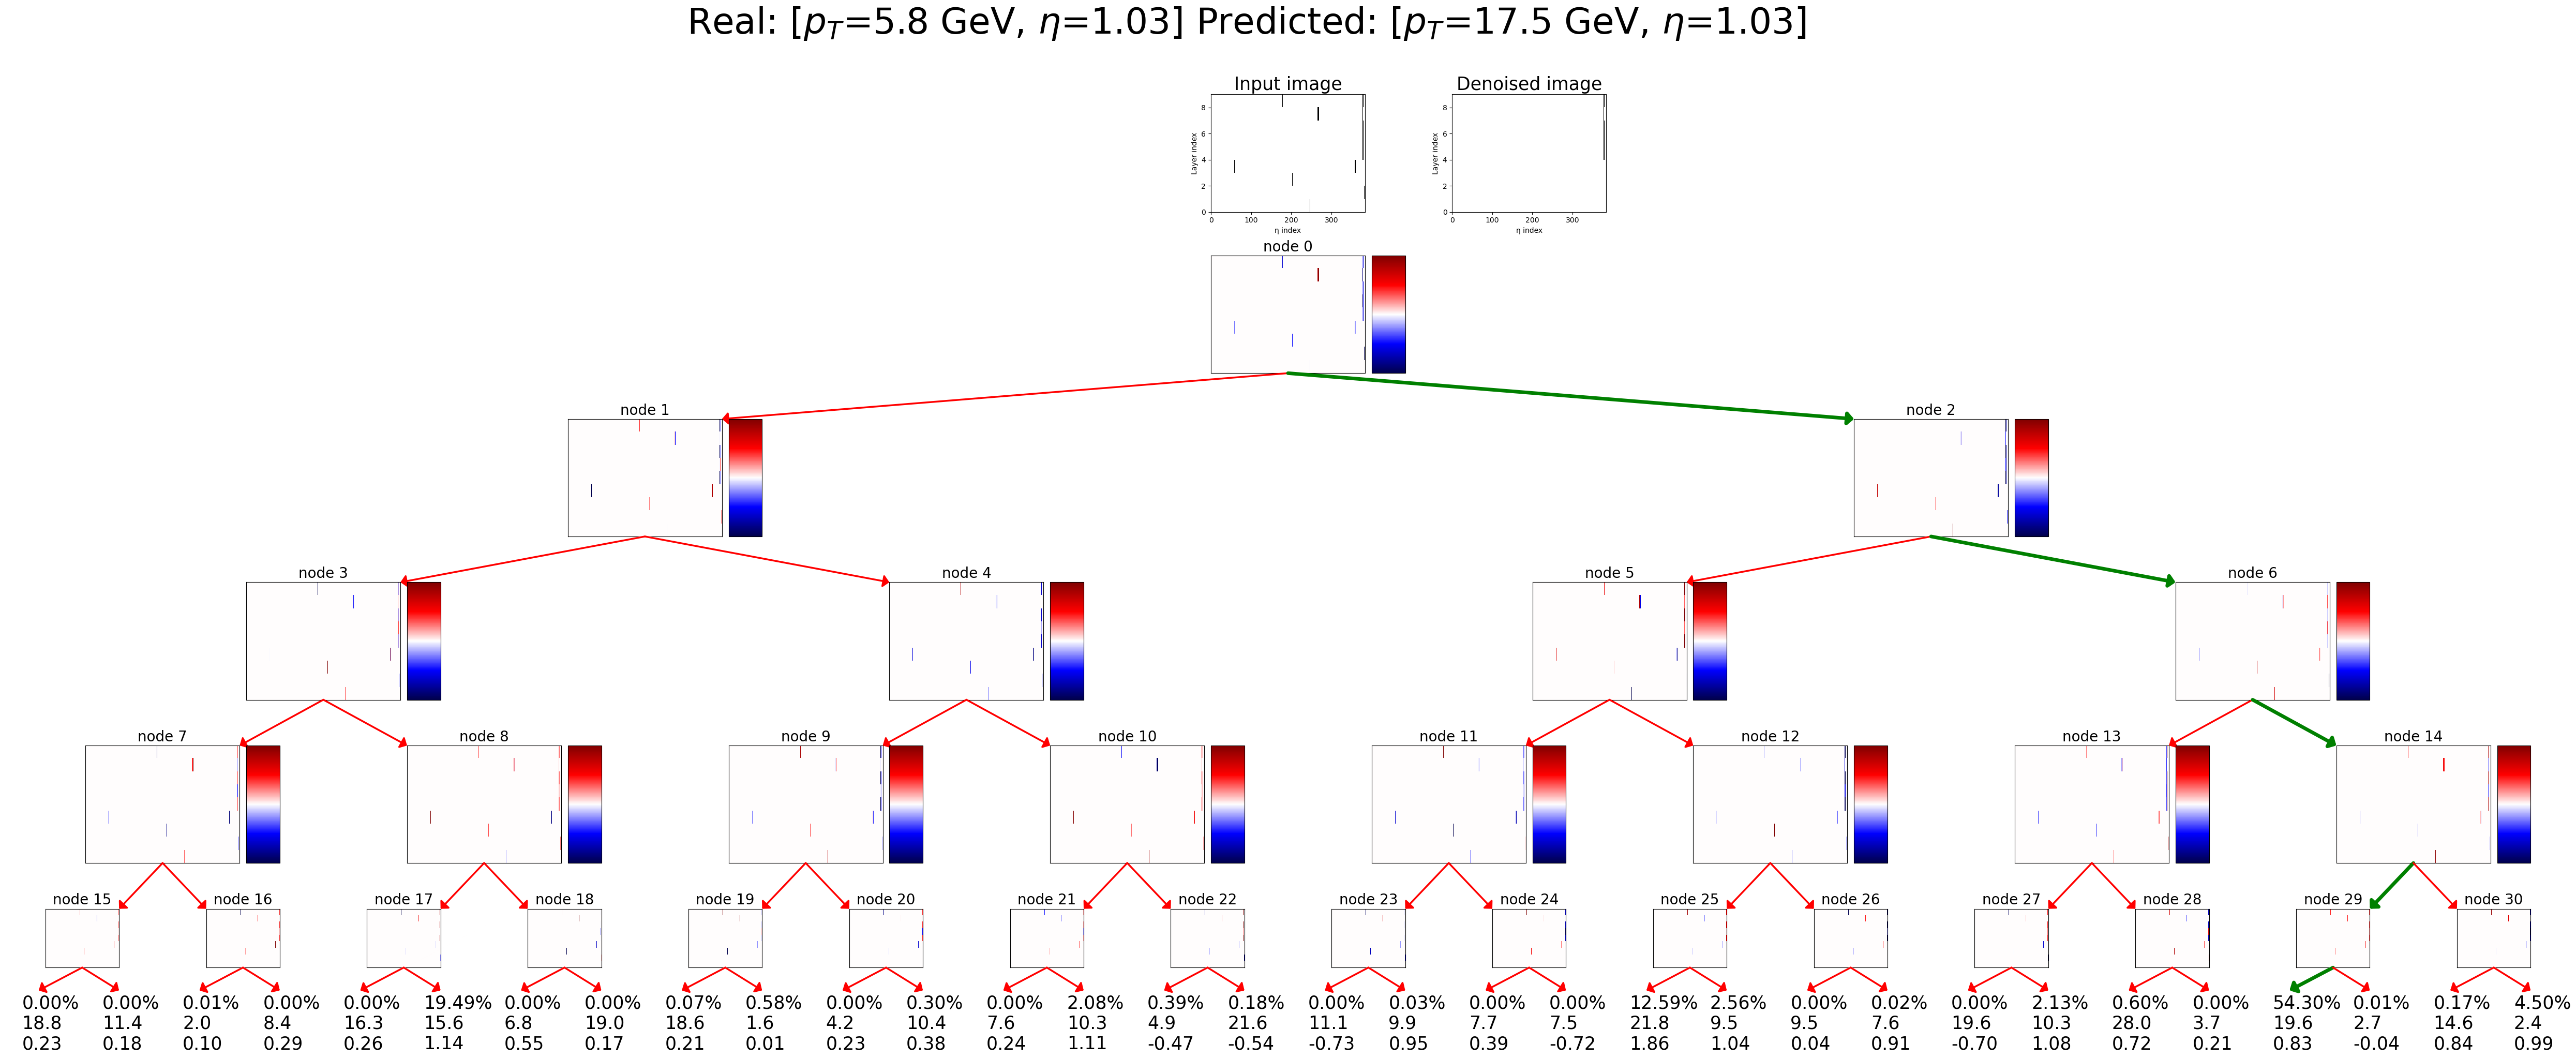


 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

############################################################  False Negatives inspection  ############################################################
Explanation for test image 81977


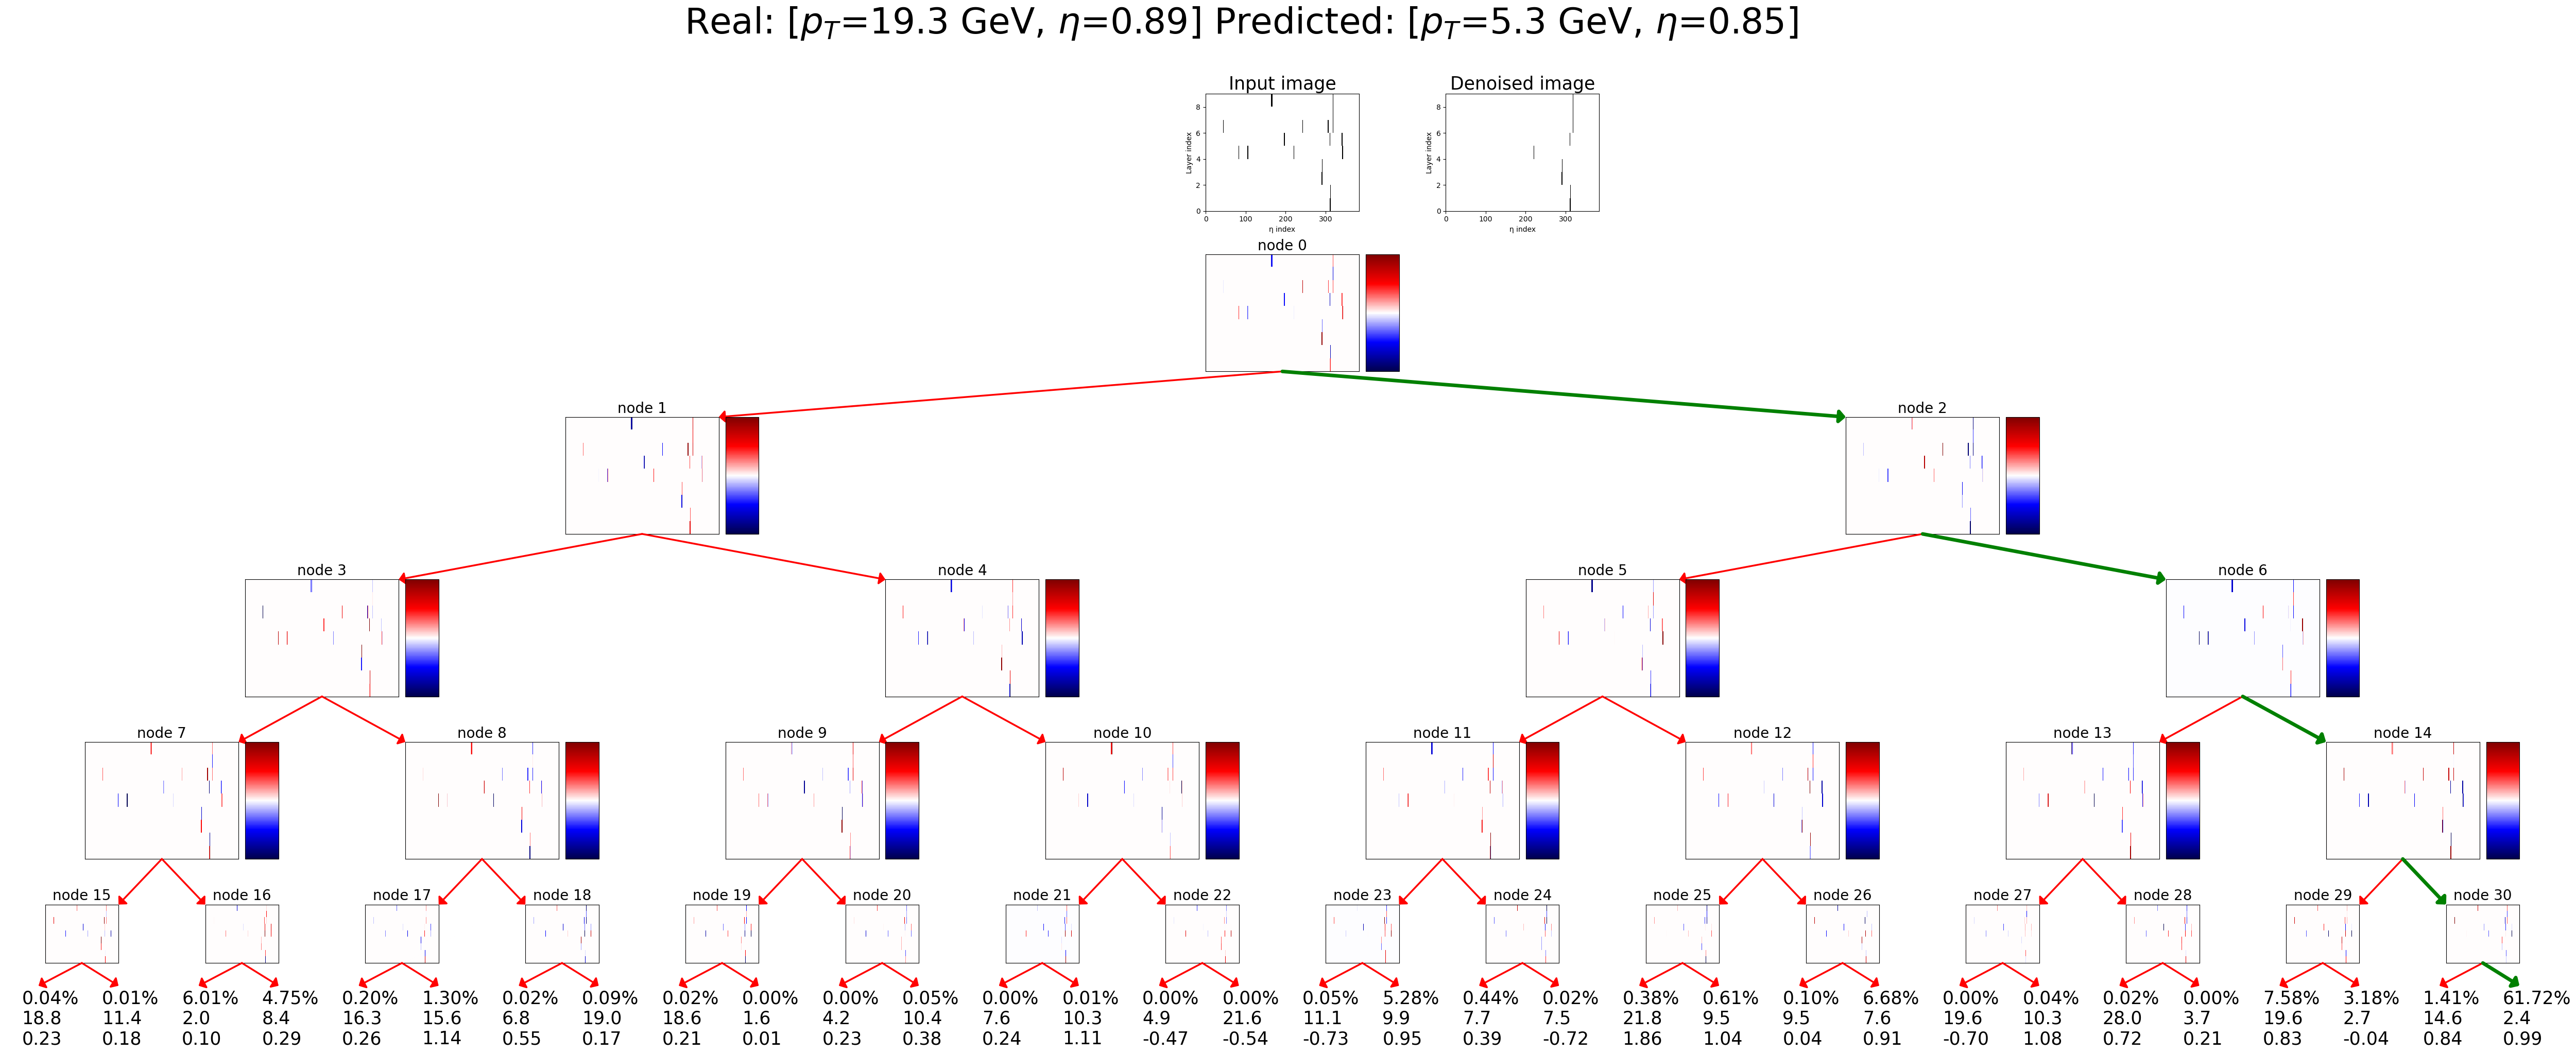


 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [17]:
# inspect not selected events: particles that have pt>15 GeV but predicted pt<10 GeV        
print(f'There are {len(fp_index)} false positives selected events.')
print(f'There are {len(fn_index)} false negatives selected events.\n')

print('#'*60, ' False Positives inspection ', '#'*60)
index = random.choice(fp_index)
while abs(compare_df.iat[index, 0] - compare_df.iat[index, 2]) < 5:
    index = random.choice(fp_index)
print('Explanation for test image ' + str(index))
explain_image(model, test_images[index], test_labels[index][0], test_labels[index][1], test_images_without_noise[index], mean=MEAN_KD, std=STD_KD, title='fp.jpg')
print('\n', '-'*160, '\n')

print('#'*60, ' False Negatives inspection ', '#'*60)
index = random.choice(fn_index)
while abs(compare_df.iat[index, 0] - compare_df.iat[index, 2]) < 5:
    index = random.choice(fn_index)
print('Explanation for test image ' + str(index))
explain_image(model, test_images[index], test_labels[index][0], test_labels[index][1], test_images_without_noise[index], mean=MEAN_KD, std=STD_KD, title='fn.jpg')
print('\n', '-'*160, '\n')

#### b. Only-noise images inspection

Finally, it's very interesting to see how the network behaves with images containing only noise and no effective patterns of the particles.

In [12]:
# what does the model predict for only-noise images?
# how many of them are predicted with a pt>15 GeV? Inspect them
# ! gdown --id 1nKHHj6ZqbS1SGkH5OYpezbYujbRlXxsi
# print('\nUnzipping data...')
# ! unzip -q images_only_noise.zip
# ! rm -rf images_only_noise.zip

print('\nLoading only-noise images...')
noise_images = np.load('../images_only_noise/images_only_noise.npy')
noise_labels = np.zeros((len(noise_images), 2))
print('\nLoading completed.')

# checking shapes of npy array
print(noise_images.shape)
print(noise_labels.shape)

noise_images = noise_images.reshape(-1, 1, 9, 384)
noise_labels = noise_labels.reshape(-1, 2)

# numpy data ---> torch tensors
noise_images = torch.tensor(noise_images, dtype=torch.float32)
noise_labels = torch.tensor(noise_labels, dtype=torch.float32)

In [13]:
# create dataloader
noise_data_list = []

for x, y in zip(noise_images, noise_labels):
    noise_data_list.append((x, y))

noise_dataset = XaiDataset(noise_data_list)
noise_dataloader = DataLoader(noise_dataset, batch_size=64)

In [45]:
# predicting only-noise images
val_pt = torch.tensor([])
val_eta = torch.tensor([])
model.eval()
with torch.no_grad():
    for data, target in tqdm(noise_dataloader, leave=False, mininterval=1):
        batch_out = model(data)
        val_pt = torch.cat((val_pt, batch_out['pred_pt']), 0)
        val_eta = torch.cat((val_eta, batch_out['pred_eta']), 0)

y_hat_pt = val_pt.detach().numpy()
y_hat_eta = val_eta.detach().numpy()

# just to not run teacher again
STD_KD = 4.761418342590332
MEAN_KD = 11.863591194152832

noise_df = pd.DataFrame(data={'pt_pred': y_hat_pt * STD_KD + MEAN_KD, 'eta_pred': y_hat_eta})
noise_df.head(10)

,pt_pred,eta_pred
0,12.997146,0.453080
1,13.083282,0.458985
2,13.135612,0.447986
3,12.938833,0.454852
4,13.035234,0.455439
5,13.034069,0.452881
6,12.991311,0.451905
7,12.939517,0.451112
8,12.742756,0.459129
9,12.977443,0.457015


In [46]:
# indices of the selected only-noises events 
onlyNoise_index = []
for i, elem in noise_df.iterrows():
    if elem['pt_pred'] > 15:
        onlyNoise_index.append(i)

############################################################  Only Noise inspection  ############################################################
Explanation for test image 663329


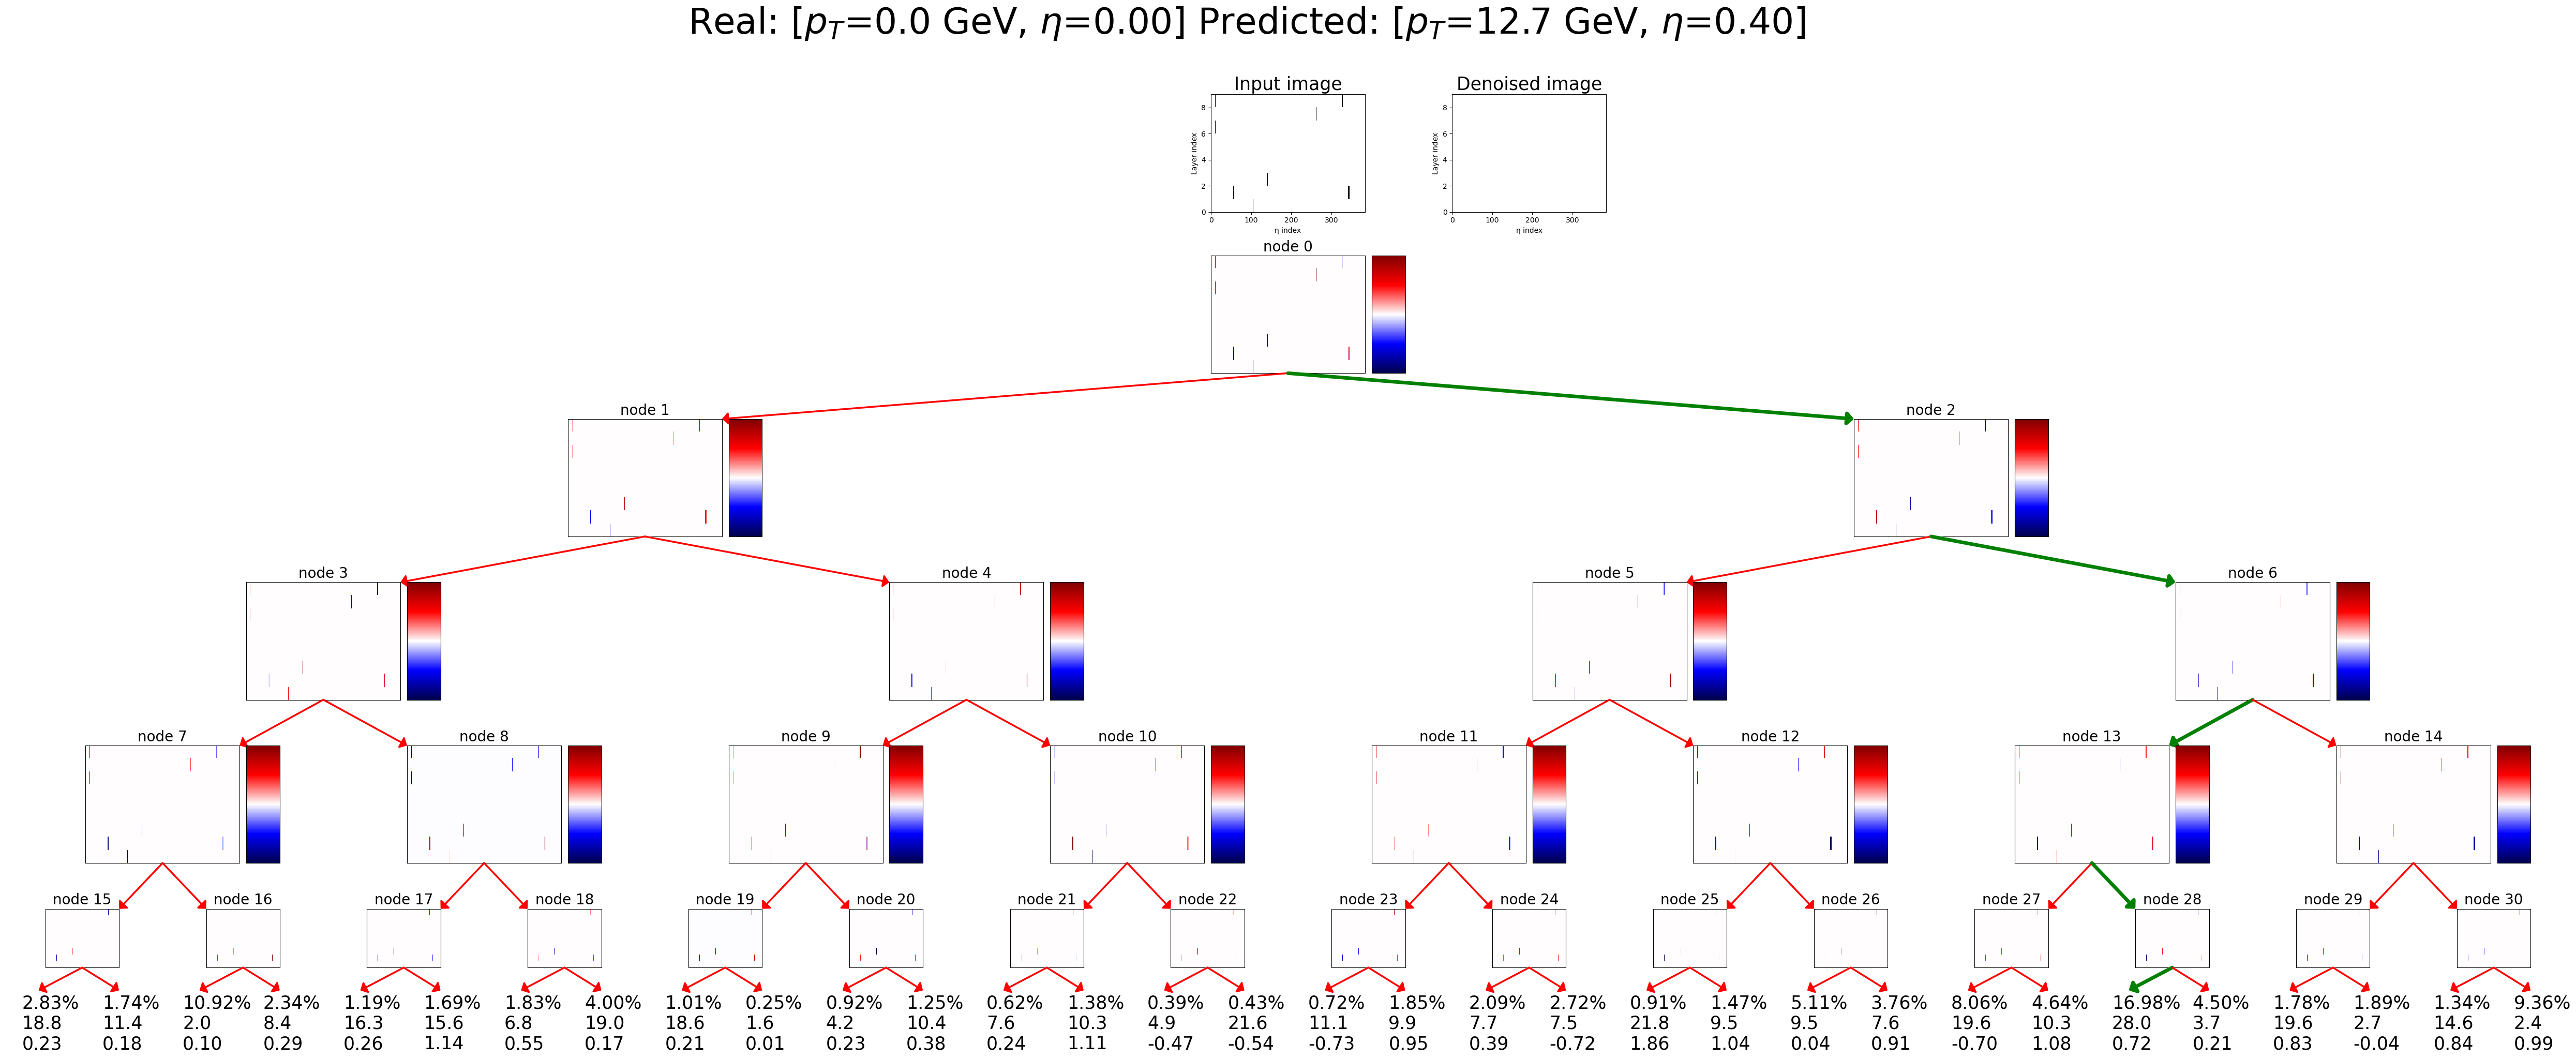


 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [20]:
print(f'There are {len(onlyNoise_index)} selected events among the only-noise images. {len(onlyNoise_index)/len(noise_images)*100:0.4f}%\n')
print('#'*60, ' Only Noise inspection ', '#'*60)

denoised_img = np.zeros((9, 384))
denoised_img[0][0] = 1

# explaining a random image of this list
index = random.choice(onlyNoise_index)
print('Explanation for test image ' + str(index))
explain_image(model, noise_images[index], noise_labels[index][0], noise_labels[index][1], denoised_img, mean=MEAN_KD, std=STD_KD, title='noise.jpg')
print('\n', '-'*160, '\n')